<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas y funciones

In [31]:
import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [32]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura y exploración de la Serie de Tiempo

In [33]:
file = 'https://raw.githubusercontent.com/AnIsAsPe/Prediccion-produccion-electricidad/main/Datos/IPG2211A2N%20_2023_01.csv'

datos = pd.read_csv(file,
                    index_col = [0],
                    parse_dates=['DATE']
                    )
datos = datos.loc['2000-01-01':]
datos.columns = ['Producción']  # NAICS 2211

datos

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-03-01,87.0234
2000-04-01,80.4433
2000-05-01,83.4549
...,...
2022-09-01,100.4154
2022-10-01,91.0391
2022-11-01,100.8168


## Asegurar el orden y la continuidad de la serie de tiempo

In [34]:
# La monotonicidad es una propiedad matemática que indica que una función
# determinada mantiene un orden no creciente o decreciente en todo su dominio

datos.index.is_monotonic_increasing

True

In [35]:
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=277, freq=None)

In [36]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=277, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

### Ejemplo de Serie discontinua

In [37]:
df  = datos.drop( [ '2015-09-01', '2019-07-01'])
df

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-03-01,87.0234
2000-04-01,80.4433
2000-05-01,83.4549
...,...
2022-09-01,100.4154
2022-10-01,91.0391
2022-11-01,100.8168


In [38]:
df.index.is_monotonic_increasing

True

In [39]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
df.index.freq = df.index.inferred_freq
df.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=275, freq=None)

In [40]:
df.index.min(), df.index.max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2023-01-01 00:00:00'))

In [41]:
# Creamos una Series de pandas con las fechas esperadas para compararlo con las
# fechas en nuestra serie de tiempo.

obsEsperadas = pd.Series(data=pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS'))

# Filtramos las fechas, en las obserbvaciones Esperadas que no aparecen en
# nuestra serie de tiempo

faltantes = obsEsperadas[~ obsEsperadas.isin(df.index)]

for i in faltantes.dt.strftime('%Y/%m/%d'):
    print(i)

2015/09/01
2019/07/01


## Exploración y Visualización de la Serie Temporal

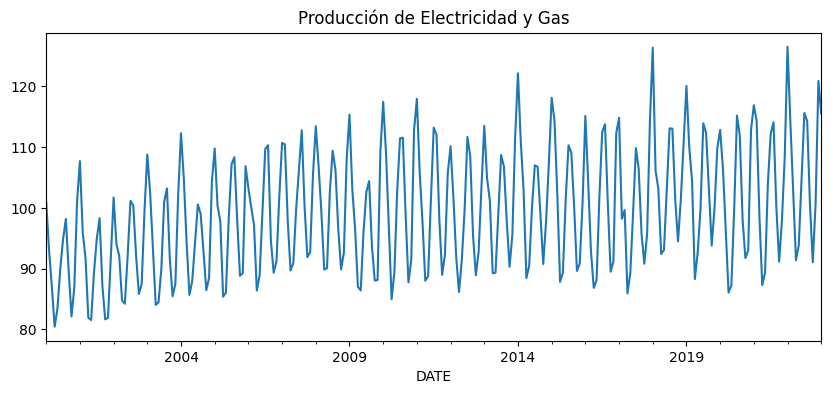

In [42]:
datos['Producción'].plot(figsize=(10,4), title='Producción de Electricidad y Gas')
plt.show()

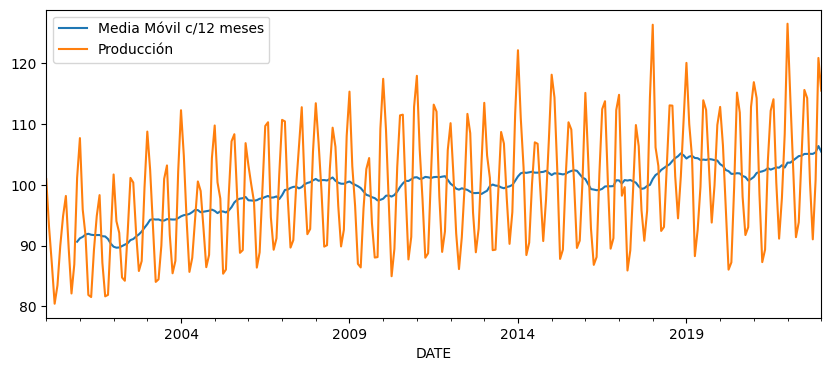

In [43]:
datos['Producción'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['Producción'].plot()
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, temporalidad y residuos.
Esta función nos permite observar la tendencia , la temporalidad, y entender si lo que resta (los residuos) se pueden modelar con un modelo ARMA).

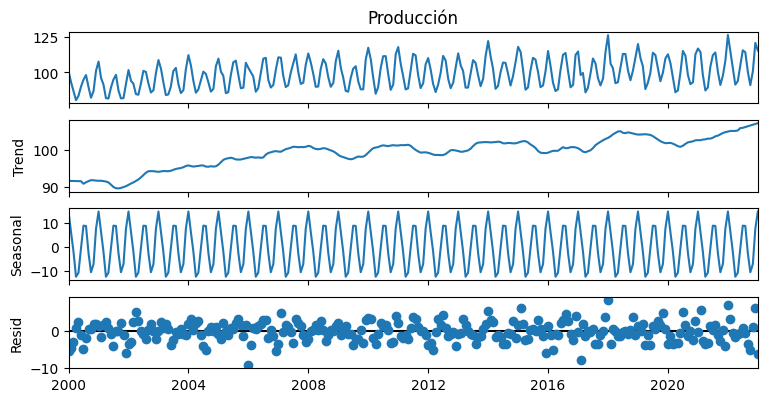

In [44]:
decomposition = seasonal_decompose(datos['Producción'], model = 'additive',
                            period=12, extrapolate_trend='freq'
                            )
fig =decomposition.plot()
fig.set_size_inches(8,4)

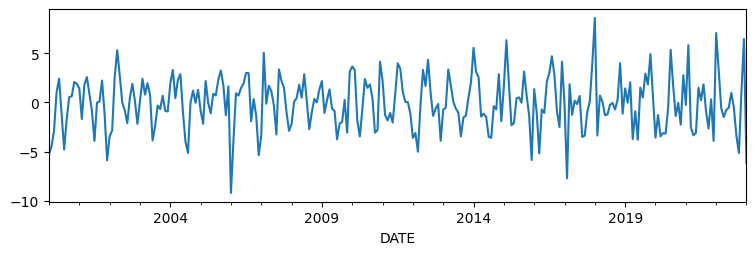

In [45]:
residuals = decomposition.resid
residuals.plot(figsize=(9,2.5))
plt.show()

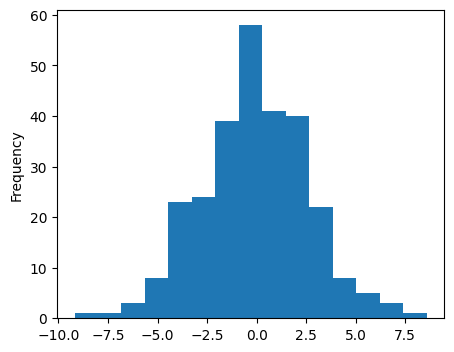

In [46]:
_ = residuals.plot.hist(figsize=(5,4), bins=15)

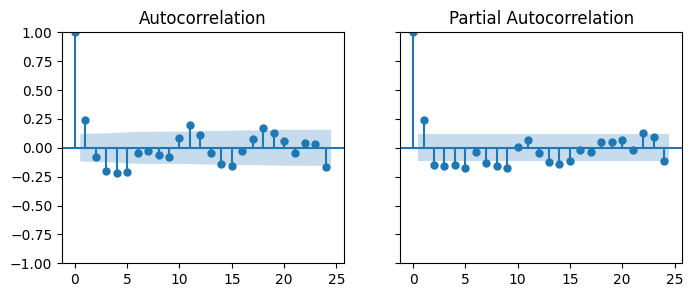

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)
plot_acf(residuals, lags=24,  ax=axes[0])
plot_pacf(residuals, lags= 24, ax=axes[1])
plt.show()

Observando las gráficas anteriores vemos que existen correlaciones que son significativas en varios retrasos (lags), por lo que pensar en modelar la serie con con un modelo ARMA, es una buena idea.

El modelo SARIMA extiende el modelo ARMA para modelar series temporales con la tendencia y la temporalidad. La componente de temporalidad incorpora terminos AR (autorregresivo), I(Integrado) y MA(Medias Móviles) especificos.

Un modelo SARIMA tiene parametros (`p`, `d`, `q`) x (`P`, `D`, `Q`, `t`)

Lo primero que vamos a hacer es investigar cuantas veces se tiene que diferenciar la serie para hacerla estacionaria, es decir, el parámetro `d`

# Construcción del modelo SARIMA



## División de la serie en entrenamiento y prueba

In [48]:
from datetime import  timedelta
from dateutil.relativedelta import relativedelta

end_month =  datos.index.max()
split_month = end_month + relativedelta(months=-12)
split_month

Timestamp('2022-01-01 00:00:00')

In [142]:
train = datos.loc[:split_month,'Producción']
test = datos.loc[split_month + relativedelta(months=1):,'Producción']

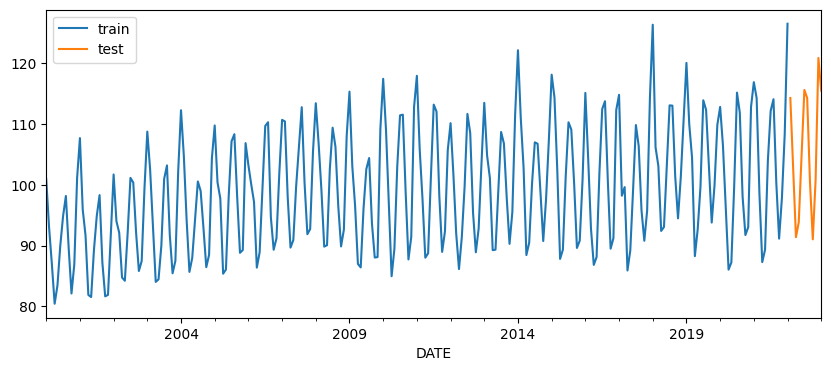

In [143]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

## Estacionariedad de la Serie (parametro d)


Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [51]:
p_value_adfuller(train)

P-value:  0.5386392168314844
No se rechaza la hipóteis nula, los datos no son estacionarios


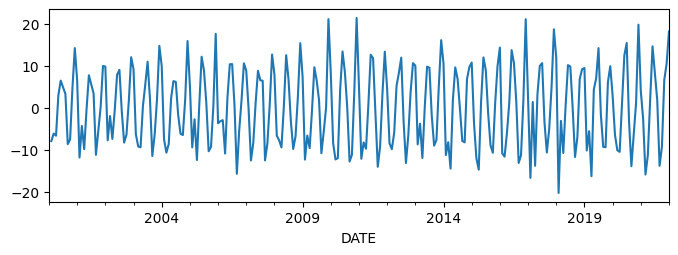

In [52]:
train_1diff = train - train.shift(1)
train_1diff.plot(figsize=(8,2.5))
plt.show()

In [53]:
p_value_adfuller(train_1diff.dropna())

P-value:  6.972297949043306e-13
Se rechaza la hipótesis nula, los datos son estacionarios


por tanto el parametro d = 1

## Orden del modelo SARIMA (p, d, q) x (P, D, Q, t)

La biblioteca `pmdarima` tiene una función `autoarima`, sin embargo la dependencia a otras bibliotecas limita su uso.

In [59]:
p =  q = range(1, 3)
pdq = list(itertools.product(p, [1], q))
pdq

[(1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2)]

In [55]:
P = D =  Q = range(0, 3)
PDQt = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
PDQt

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

En cualquier búsqueda de parámetros, se recomienda comenzar la busqueda haciendo uso de los hallazgos de la exploración y limitar el espacio de busqueda para despues, si es necesario, incrementar gradualmente la búsqueda.

In [57]:
# %%time
# aic_modelos = {}
# for parametros in pdq:        # ARIMA (p, d, q)
#   for parametros_s in PDQt:   # S - Temporalidad (P, D, Q, t)
#       modelo = SARIMAX(train,
#                        order = parametros,             # ARIMA
#                        seasonal_order = parametros_s,  # Temporalidad
#                        enforce_stationarity = False,
#                        enforce_invertibility = False   # permite que el polinomio de promedio móvil no sea invertible,
#                                                        # de modo que la mayoría de los modelos sean estimables.
#                        )
#       results = modelo.fit()
#       aic_modelos[parametros, parametros_s] = results.aic
#       print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))

ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:1911.9389894338033
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:1648.125312567458
ARIMA(0, 1, 0) x (0, 0, 2, 12) - AIC:1497.6281173862913
ARIMA(0, 1, 0) x (0, 1, 0, 12) - AIC:1419.9459736730503
ARIMA(0, 1, 0) x (0, 1, 1, 12) - AIC:1268.527505708967
ARIMA(0, 1, 0) x (0, 1, 2, 12) - AIC:1209.7075023120194
ARIMA(0, 1, 0) x (0, 2, 0, 12) - AIC:1577.3384109987387
ARIMA(0, 1, 0) x (0, 2, 1, 12) - AIC:1329.481266394319
ARIMA(0, 1, 0) x (0, 2, 2, 12) - AIC:1196.4345818202141
ARIMA(0, 1, 0) x (1, 0, 0, 12) - AIC:1418.9978584339397
ARIMA(0, 1, 0) x (1, 0, 1, 12) - AIC:1324.219296847598
ARIMA(0, 1, 0) x (1, 0, 2, 12) - AIC:1265.5628607917874
ARIMA(0, 1, 0) x (1, 1, 0, 12) - AIC:1340.9461673139335
ARIMA(0, 1, 0) x (1, 1, 1, 12) - AIC:1274.3166899411622
ARIMA(0, 1, 0) x (1, 1, 2, 12) - AIC:1209.0819323951196
ARIMA(0, 1, 0) x (1, 2, 0, 12) - AIC:1439.3975283167251
ARIMA(0, 1, 0) x (1, 2, 1, 12) - AIC:1316.7959381736289
ARIMA(0, 1, 0) x (1, 2, 2, 12) - AIC:1198.4306823113

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 0, 2, 12) - AIC:1189.6059195931757
ARIMA(1, 1, 2) x (2, 1, 0, 12) - AIC:1180.2625430366618
ARIMA(1, 1, 2) x (2, 1, 1, 12) - AIC:1141.0663182200024
ARIMA(1, 1, 2) x (2, 1, 2, 12) - AIC:1128.5841602284108
ARIMA(1, 1, 2) x (2, 2, 0, 12) - AIC:1261.028499120743
ARIMA(1, 1, 2) x (2, 2, 1, 12) - AIC:1165.4373341412922
ARIMA(1, 1, 2) x (2, 2, 2, 12) - AIC:1131.0645333326388
ARIMA(2, 1, 0) x (0, 0, 0, 12) - AIC:1740.0229582763195
ARIMA(2, 1, 0) x (0, 0, 1, 12) - AIC:1584.2980800580533
ARIMA(2, 1, 0) x (0, 0, 2, 12) - AIC:1468.3372226362453
ARIMA(2, 1, 0) x (0, 1, 0, 12) - AIC:1376.400253065843
ARIMA(2, 1, 0) x (0, 1, 1, 12) - AIC:1238.8749562618277
ARIMA(2, 1, 0) x (0, 1, 2, 12) - AIC:1177.3385894084126
ARIMA(2, 1, 0) x (0, 2, 0, 12) - AIC:1529.8724826190994
ARIMA(2, 1, 0) x (0, 2, 1, 12) - AIC:1290.9745733030518
ARIMA(2, 1, 0) x (0, 2, 2, 12) - AIC:1163.8619784105063
ARIMA(2, 1, 0) x (1, 0, 0, 12) - AIC:1374.8499854849488
ARIMA(2, 1, 0) x (1, 0, 1, 12) - AIC:1283.46366825

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 0, 1, 12) - AIC:1255.2694067572104
ARIMA(2, 1, 2) x (1, 0, 2, 12) - AIC:1198.497837465746
ARIMA(2, 1, 2) x (1, 1, 0, 12) - AIC:1273.3657710875796


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 1, 1, 12) - AIC:1202.1368596869434
ARIMA(2, 1, 2) x (1, 1, 2, 12) - AIC:1141.5246117924517
ARIMA(2, 1, 2) x (1, 2, 0, 12) - AIC:1370.945248448471
ARIMA(2, 1, 2) x (1, 2, 1, 12) - AIC:1251.2488921487611


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 2, 2, 12) - AIC:1133.1724629656067
ARIMA(2, 1, 2) x (2, 0, 0, 12) - AIC:1272.0242765067615


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 0, 1, 12) - AIC:1208.390296530094


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 0, 2, 12) - AIC:1191.6414209921052
ARIMA(2, 1, 2) x (2, 1, 0, 12) - AIC:1175.9769422646973
ARIMA(2, 1, 2) x (2, 1, 1, 12) - AIC:1135.413698804183
ARIMA(2, 1, 2) x (2, 1, 2, 12) - AIC:1130.2817737810692
ARIMA(2, 1, 2) x (2, 2, 0, 12) - AIC:1257.7327011012644
ARIMA(2, 1, 2) x (2, 2, 1, 12) - AIC:1162.2486330129254
ARIMA(2, 1, 2) x (2, 2, 2, 12) - AIC:1132.2950193340807
CPU times: user 7min 10s, sys: 10.3 s, total: 7min 21s
Wall time: 7min 28s


Con la celda anterior en colab fueron 7 min 28 seg.

In [58]:
%%time
from joblib import Parallel, delayed

def fit_sarimax_model(parametros, parametros_s):
      modelo = SARIMAX(train, order=parametros, seasonal_order=parametros_s, enforce_stationarity=False, enforce_invertibility=False)
      results = modelo.fit()
      return (parametros, parametros_s), results.aic

results = Parallel(n_jobs=-1)(delayed(fit_sarimax_model)(parametros, parametros_s) for parametros in pdq for parametros_s in PDQt)
aic_modelos = dict(results)

CPU times: user 2.94 s, sys: 541 ms, total: 3.48 s
Wall time: 6min 10s


In [60]:
aic_modelos

{((0, 1, 0), (0, 0, 0, 12)): 1911.9389894338033,
 ((0, 1, 0), (0, 0, 1, 12)): 1648.125312567458,
 ((0, 1, 0), (0, 0, 2, 12)): 1497.628117386293,
 ((0, 1, 0), (0, 1, 0, 12)): 1419.9459736730503,
 ((0, 1, 0), (0, 1, 1, 12)): 1268.527505708967,
 ((0, 1, 0), (0, 1, 2, 12)): 1209.7075023119748,
 ((0, 1, 0), (0, 2, 0, 12)): 1577.3384109987387,
 ((0, 1, 0), (0, 2, 1, 12)): 1329.481266394319,
 ((0, 1, 0), (0, 2, 2, 12)): 1196.4345818194174,
 ((0, 1, 0), (1, 0, 0, 12)): 1418.9978584339397,
 ((0, 1, 0), (1, 0, 1, 12)): 1324.219296847598,
 ((0, 1, 0), (1, 0, 2, 12)): 1265.5628607917306,
 ((0, 1, 0), (1, 1, 0, 12)): 1340.9461673139335,
 ((0, 1, 0), (1, 1, 1, 12)): 1274.3166899411622,
 ((0, 1, 0), (1, 1, 2, 12)): 1209.0819323949695,
 ((0, 1, 0), (1, 2, 0, 12)): 1439.3975283167251,
 ((0, 1, 0), (1, 2, 1, 12)): 1316.7959381736289,
 ((0, 1, 0), (1, 2, 2, 12)): 1198.4306823177267,
 ((0, 1, 0), (2, 0, 0, 12)): 1339.6930511956175,
 ((0, 1, 0), (2, 0, 1, 12)): 1275.5503103591482,
 ((0, 1, 0), (2, 0, 2, 12

El criterio de información de Akaike ([AIC](https://es.wikipedia.org/wiki/Criterio_de_informaci%C3%B3n_de_Akaike)) es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos.

Considera la bondad de ajuste del modelo a los datos, pero también la complejidad del modelo (número de parámetros)

AIC ofrece una estimación relativa de la información perdida cuando se utiliza un modelo determinado para representar el proceso que genera los datos

In [61]:
modelo = min(aic_modelos, key = aic_modelos.get)
print('Modelo: ', modelo )
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((1, 1, 2), (0, 2, 2, 12))
AIC:  1127.8508504205354


In [63]:
modelo = SARIMAX(train,
                #  order = (modelo[0]),
                #  seasonal_order = modelo[1],
                 order = (1, 1, 2),
                 seasonal_order = (0, 2, 3, 12),
                 enforce_stationarity = False,
                 enforce_invertibility = False)
resultados = modelo.fit()
resultados.aic

1069.1029507930002

In [67]:
modelo = SARIMAX(train,
                #  order = modelo[0],
                #  seasonal_order = modelo[1],
                 order = (1, 1, 2),
                 seasonal_order = (0, 2, 3, 12),
                 enforce_stationarity = False,
                 enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5751      0.220      2.611      0.009       0.143       1.007
ma.L1         -1.1591      0.245     -4.723      0.000      -1.640      -0.678
ma.L2          0.2035      0.211      0.966      0.334      -0.209       0.616
ma.S.L12      -1.7013   2011.699     -0.001      0.999   -3944.559    3941.156
ma.S.L24       0.4931   1532.587      0.000      1.000   -3003.322    3004.308
ma.S.L36       0.2586    530.847      0.000      1.000   -1040.182    1040.700
sigma2         8.4247   1.73e+04      0.000      1.000   -3.39e+04    3.39e+04


## Validación#

### Análisis de los residuos del modelo

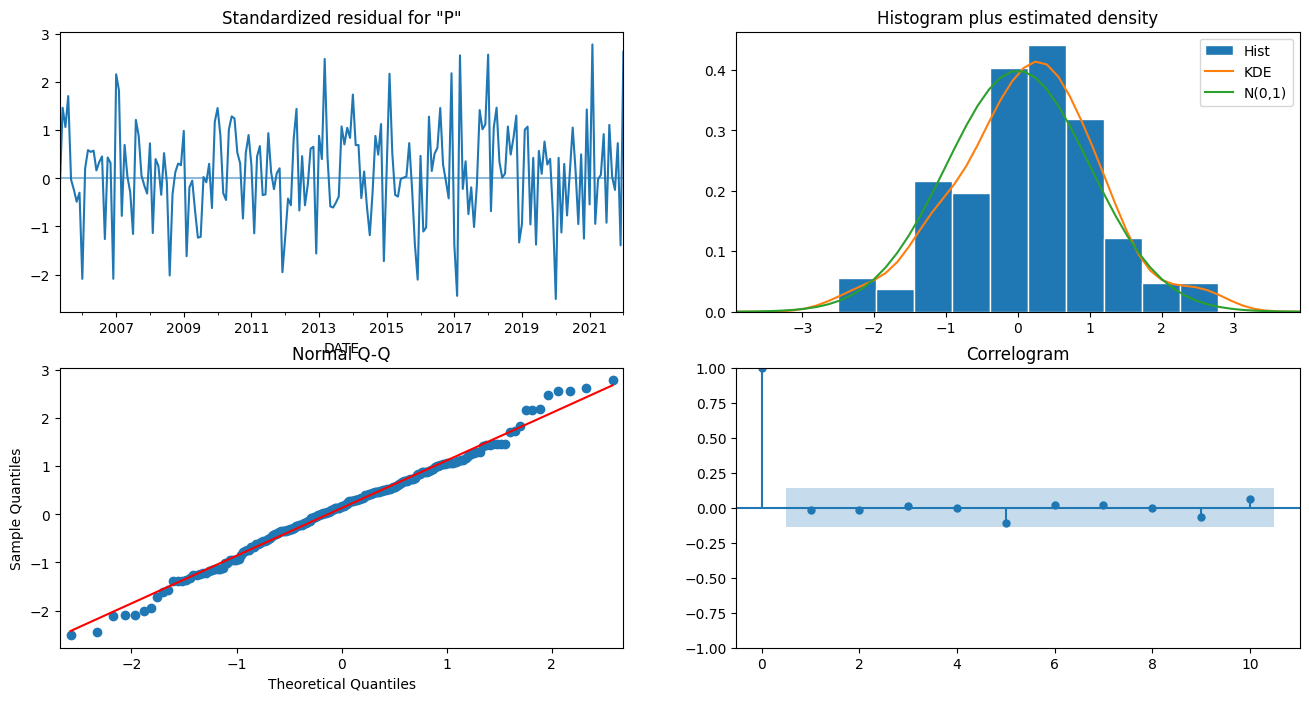

In [68]:
resultados.plot_diagnostics(figsize = (16,8))
plt.show()

###  Predicción y evaluación del modelo

In [144]:
pred = resultados.get_prediction(start = split_month + pd.DateOffset(months=1),
                                 end =end_month)
pred.predicted_mean

,predicted_mean
2022-02-01,112.239020
2022-03-01,101.464024
2022-04-01,88.437587
2022-05-01,90.711760
2022-06-01,103.013497
2022-07-01,113.640928
2022-08-01,112.737710
2022-09-01,100.904205
2022-10-01,91.821912
2022-11-01,98.177357


In [145]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower Producción,upper Producción
2022-02-01,106.288380,118.189661
2022-03-01,95.018070,107.909978
2022-04-01,81.773154,95.102019
2022-05-01,83.933003,97.490517
2022-06-01,96.164478,109.862516
2022-07-01,106.742069,120.539786
2022-08-01,105.799198,119.676222
2022-09-01,93.931413,107.876996
2022-10-01,84.817801,98.826024
2022-11-01,91.143611,105.211102


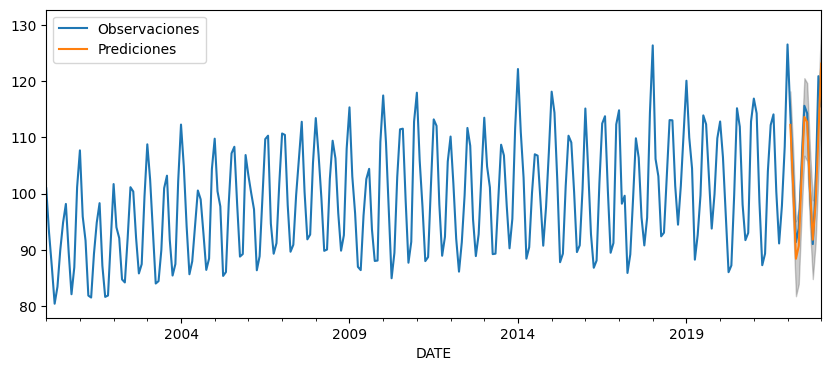

In [146]:
fig = datos.loc[:,'Producción'].plot(label = 'Observaciones',
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2)
plt.legend()
plt.show()

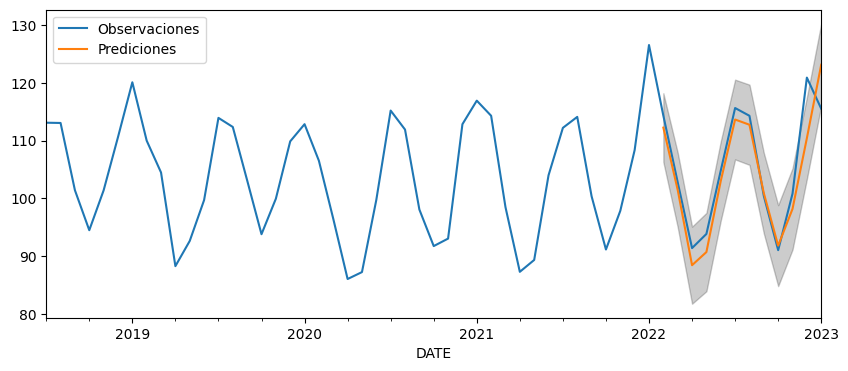

In [147]:
fig = datos.loc['2018-07-01':,'Producción'].plot(label = 'Observaciones',
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [148]:
y_pred  = pred.predicted_mean
y_real = datos.loc[split_month:end_month,'Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 17.48
La raiz del error cuadrático medio es 4.18


# Prophet

Prophet es un procedimiento de predicción de datos de series temporales **univariadas** basado en un modelo **aditivo** en el que las tendencias no lineales se ajustan con estacionalidad anual, semanal y diaria, además de efectos de vacaciones.

Su uso es muy recomendable en series temporales con una fuerte estacionalidad y efectos de dias festivos/vacaciones y eventos especiales.

El diseño de Prophet lo hae robusto en casos de valores faltantes y valores atipicos en la serie temporal.



In [187]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [188]:
df_Prophet = datos.reset_index()
df_Prophet.columns = ['ds', 'y']
df_Prophet

,ds,y
0,2000-01-01,100.9623
1,2000-02-01,93.1065
2,2000-03-01,87.0234
3,2000-04-01,80.4433
4,2000-05-01,83.4549
...,...,...
272,2022-09-01,100.4154
273,2022-10-01,91.0391
274,2022-11-01,100.8168
275,2022-12-01,120.8932


In [189]:
train_Prophet = df_Prophet.loc[:(276-12)]


In [190]:
model_prophet = Prophet(yearly_seasonality=True, interval_width=0.95)
model_prophet.fit(train_Prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ywonwcf/h70hdaw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ywonwcf/mgg3bd1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18689', 'data', 'file=/tmp/tmp0ywonwcf/h70hdaw4.json', 'init=/tmp/tmp0ywonwcf/mgg3bd1r.json', 'output', 'file=/tmp/tmp0ywonwcf/prophet_modelfdpoakcr/prophet_model-20250313213431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [191]:
# Creamos el datafreme para los datos que queremos predecir
future_data = model_prophet.make_future_dataframe(periods=12, freq='MS')

In [192]:
future_data

,ds
0,2000-01-01
1,2000-02-01
2,2000-03-01
3,2000-04-01
4,2000-05-01
...,...
272,2022-09-01
273,2022-10-01
274,2022-11-01
275,2022-12-01


In [193]:
# Hacemos las predicciones
pred_Prophet = model_prophet.predict(future_data)

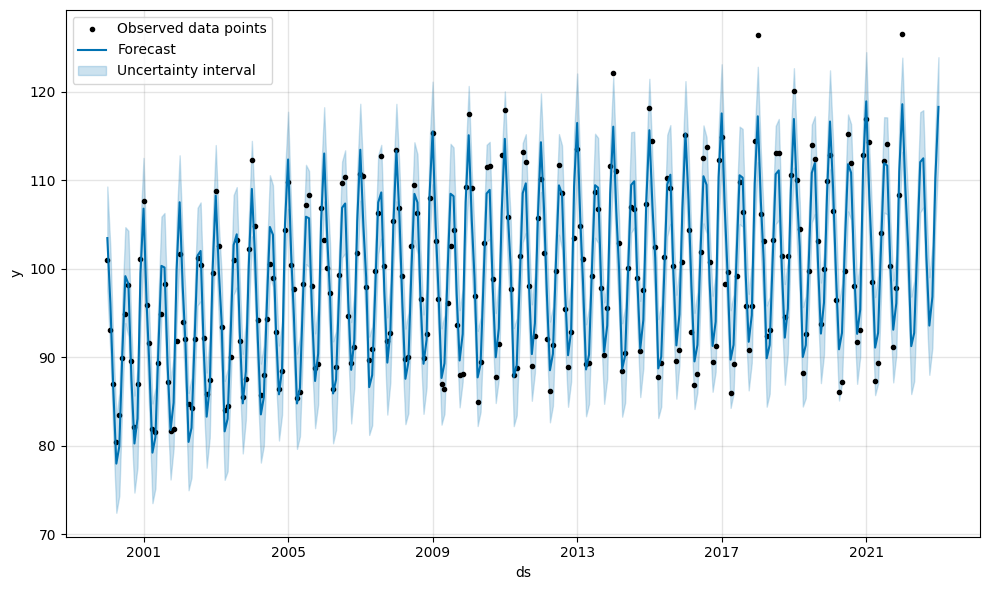

In [194]:
# Visualizamos la predicción
fig = model_prophet.plot(pred_Prophet, include_legend= True)


In [195]:
# Create a DataFrame for the recession period
recession_periods = pd.DataFrame([
    {'holiday':'economic_recession_1', 'ds':'2001-03-01', 'lower_window':0, 'ds_upper':'2001-11-01'},
    {'holiday':'economic_recession_2', 'ds':'2007-12-01', 'lower_window':0, 'ds_upper':'2009-06-01'},
    {'holiday':'economic_recession_3', 'ds':'2020-02-01', 'lower_window':0, 'ds_upper':'2020-04-01'},
])


recession_periods['ds'] = pd.to_datetime(recession_periods['ds'])
recession_periods['ds_upper'] = pd.to_datetime(recession_periods['ds_upper'])

year_diff = recession_periods['ds_upper'].dt.year - recession_periods['ds'].dt.year
month_diff = recession_periods['ds_upper'].dt.month - recession_periods['ds'].dt.month

recession_periods['upper_window'] = year_diff * 12 + month_diff
recession_periods

,holiday,ds,lower_window,ds_upper,upper_window
0,economic_recession_1,2001-03-01,0,2001-11-01,8
1,economic_recession_2,2007-12-01,0,2009-06-01,18
2,economic_recession_3,2020-02-01,0,2020-04-01,2


In [196]:
model_prophet2 = Prophet(yearly_seasonality=True,
                         interval_width=0.95,
                         holidays=recession_periods)
model_prophet2.fit(train_Prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ywonwcf/e768c6fc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ywonwcf/6i8w0nkj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95363', 'data', 'file=/tmp/tmp0ywonwcf/e768c6fc.json', 'init=/tmp/tmp0ywonwcf/6i8w0nkj.json', 'output', 'file=/tmp/tmp0ywonwcf/prophet_model2omoqugd/prophet_model-20250313213445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:34:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [197]:
# Creamos el datafreme para los datos que queremos predecir
future_data2 = model_prophet2.make_future_dataframe(periods=12, freq='MS')
pred_Prophet2 = model_prophet2.predict(future_data)

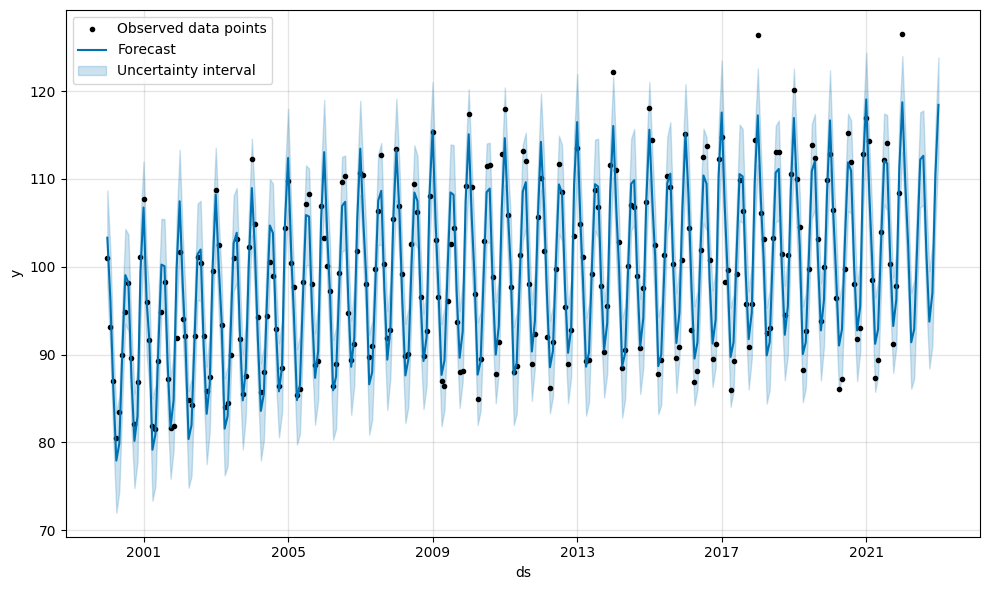

In [198]:
fig2 = model_prophet2.plot(pred_Prophet2, include_legend= True)

In [203]:
pred_Prophet2.set_index('ds', inplace = True)
inicio_pred = '2022-02-01'
pred_Prophet2.loc[inicio_pred:, 'yhat']

,yhat
ds,
2022-02-01,109.209999
2022-03-01,102.439557
2022-04-01,91.394165
2022-05-01,92.894361
2022-06-01,102.772615
2022-07-01,112.221167
2022-08-01,112.643665
2022-09-01,101.606531
2022-10-01,93.745008


In [176]:
int_conf_Prophet2 = pred_Prophet[[ 'yhat_lower', 'yhat_upper']]
int_conf_Prophet2.iloc[-12:]

,yhat_lower,yhat_upper
ds,,
2022-02-01,103.583123,114.348635
2022-03-01,96.849045,108.216901
2022-04-01,85.335806,96.931835
2022-05-01,87.359564,98.499194
2022-06-01,97.243433,108.649828
2022-07-01,106.426357,117.651073
2022-08-01,107.130763,117.954240
2022-09-01,95.334258,106.701480
2022-10-01,88.098566,99.148107


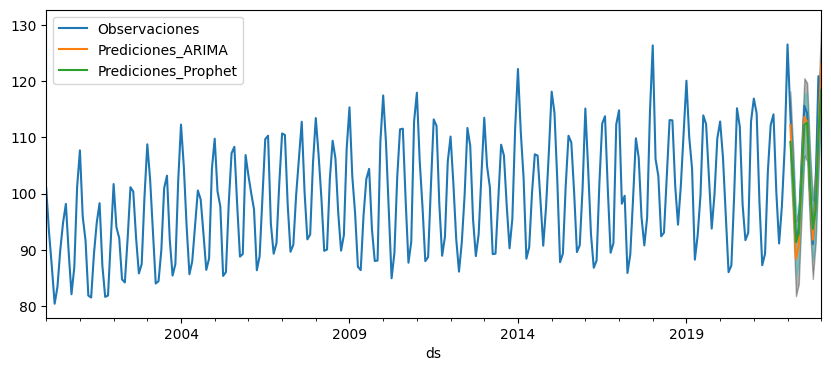

In [204]:
fig = datos.loc[:,'Producción'].plot(label = 'Observaciones',
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones_ARIMA')
pred_Prophet2.loc[inicio_pred:,'yhat'].plot(ax = fig, label = 'Prediciones_Prophet')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.3)
fig.fill_between(int_conf_Prophet2.iloc[-12:].index,
                 int_conf_Prophet2.iloc[-12:,0], int_conf_Prophet2.iloc[-12:,1],
                 color='c', alpha=.23)
plt.legend()
plt.show()

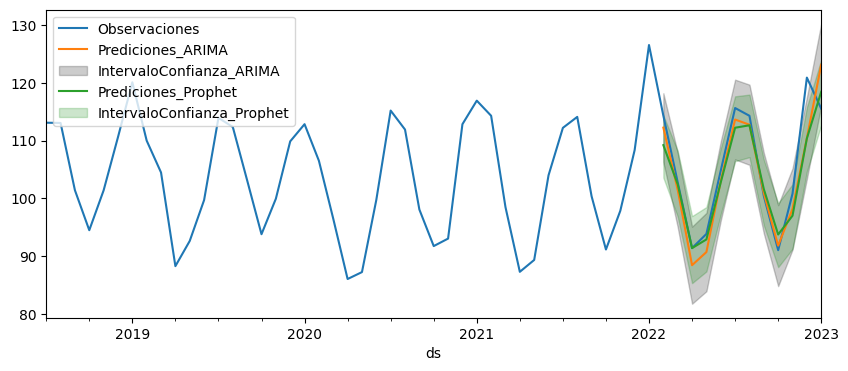

In [205]:
fig = datos.loc['2018-07-01':,'Producción'].plot(label = 'Observaciones',
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones_ARIMA')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2, label='IntervaloConfianza_ARIMA')

pred_Prophet2.loc[inicio_pred:,'yhat'].plot(ax = fig, label = 'Prediciones_Prophet')
fig.fill_between(int_conf_Prophet2.iloc[-12:].index,
                 int_conf_Prophet2.iloc[-12:,0], int_conf_Prophet2.iloc[-12:,1],
                 color='g', alpha=.2, label='IntervaloConfianza_Prophet')
plt.legend()
plt.show()

In [207]:
y_pred  = pred_Prophet2.loc[inicio_pred:,'yhat']
y_real = datos.loc[inicio_pred:end_month,'Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 15.67
La raiz del error cuadrático medio es 3.96
